#  Understanding the Relationship between Climate and Tree growth in Sukakpak AK

![Screen Shot 2019-11-18 at 2 43 52 PM](https://user-images.githubusercontent.com/46793400/69091629-b1668400-0a18-11ea-9920-9ca70946fe61.png)"

#### Motivation
- 700 years of well correlated tree ring samples , both of living and deadwood for white spruce
- originally sampled in 1979 and updated in 2010, it hasn't been published- not straight forward for dendroclimatology 
- density of the same rings gives high correlations to mean JJA temp (expected for Tree line

In [14]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime #to convert RW index to datetime
from matplotlib import pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Ring width (RW) dataset
- Pre-standardized, truncated for the calibration period (1901-2008)

In [15]:
rw=pd.read_csv('RWstd1901.csv')
a=rw['RW'].values


### CRU gridpoint data for Sukakpak, AK
- this data was compiled based on avg gridpoints for sites logged NOAA INTERNATIONAL TREE RING DATABASE (site code: ak106) 


In [16]:
#read in database data
cru=pd.read_csv('CRUsuk.csv',parse_dates = {'date_col' : ["YEAR", "MONTH"]}, keep_date_col=True )

cru['date_col'] = pd.to_datetime(cru['date_col'])
cru = cru.drop(cru.columns[[1,2,3,4]], axis=1)
df = cru.set_index('date_col')
cru.head()

,date_col,PCP,TMX,TMN,TMD
0,1901-01-01,3.0,-23.4,-33.2,-28.30
1,1901-02-01,5.0,-21.5,-33.4,-27.45
2,1901-03-01,8.0,-13.4,-25.8,-19.60
3,1901-04-01,3.0,-6.0,-17.7,-11.85
4,1901-05-01,7.0,5.6,-5.0,0.30


In [17]:
df = cru.set_index('date_col') #set index of years
df.head()


,PCP,TMX,TMN,TMD
date_col,,,,
1901-01-01,3.0,-23.4,-33.2,-28.30
1901-02-01,5.0,-21.5,-33.4,-27.45
1901-03-01,8.0,-13.4,-25.8,-19.60
1901-04-01,3.0,-6.0,-17.7,-11.85
1901-05-01,7.0,5.6,-5.0,0.30


## Convert CRU DF to xarray DS, and index by season

In [18]:
dm=df.to_xarray() #convert DF to XR DA
dm  = dm.rename({ 'date_col': 'time', })
dm = xr.decode_cf(dm)

#data variables
p=dm.PCP
tmin=dm.TMN
tmax=dm.TMX
tavg=dm.TMD

## 2A. for loop to index CRU in time, than standardize the variables to minimize outliers
- set up dictionary with keys and place to store values
- boolean: make sure we truncate CRU to same year as RW
- pulling out the seasons, per year, and take an average
- z score
- compile the series with Seasons as key

In [19]:
#For loop for pulling out seasonal data, standardizing them
x = {'p':p,'tmin': tmin,'tmax': tmax,'tavg':tavg} #assign dictionary 
y = {}
for key,val in x.items(): #assigning 
    #winter season
    DJF = val.where((val['time.season']=='DJF') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    DJFstd=((DJF-DJF.mean(dim='year')))/DJF.std(dim='year')
    #spring season 
    MAM =  val.where((val['time.season']=='MAM') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    MAMstd=((MAM-MAM.mean(dim='year')))/MAM.std(dim='year')
    #summer season
    JJA = val.where((val['time.season']=='JJA') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    JJAstd=((JJA-JJA.mean(dim='year')))/JJA.std(dim='year')
    #fall season
    SON = val.where((val['time.season']=='SON') & (val['time.year']<=2008),drop=True).groupby('time.year').mean(dim='time')
    SONstd=((SON-SON.mean(dim='year')))/SON.std(dim='year')
    seasons = pd.Series([DJFstd,MAMstd,JJAstd,SONstd], index = ['DJF', 'MAM', 'JJA', 'SON'])
    y[key] = seasons

### 2B. make 4 data frames , 1 for each climate variable ,with RW and seasonal means in the columns 

In [20]:
#part 3, make data frame for correlation analysis - this part is prepping the data for each DF
years=rw['Year'] #setting up for index 
dfs = []

for key,value in y.items():
    d = {'RW': a, 'DJF': value['DJF'].values, 'MAM': value['MAM'].values, 'JJA': value['JJA'].values , 'SON': value['SON'].values}
    dfs.append(d)

In [21]:
#putting results into data frames with years as Index
p_DF = pd.DataFrame(data=dfs[0], index=years)
tmin_DF = pd.DataFrame(data=dfs[1], index=years)
tmax_DF = pd.DataFrame(data=dfs[2], index=years)
tavg_DF = pd.DataFrame(data=dfs[3], index=years)

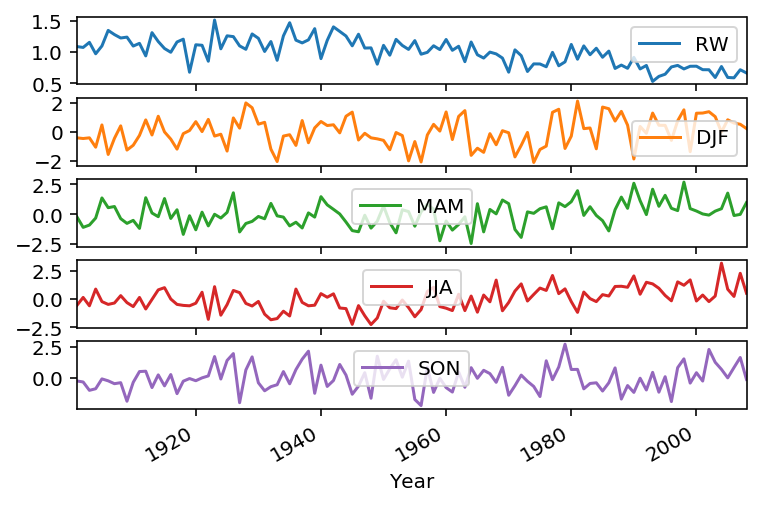

In [22]:
x=tavg_DF.plot(subplots=True)


## 3A. correlation maps (1901-2008)
- for Ring Widths vs. Seasonality of Variables
- seaborn sns , get the corr coeficient for timespan

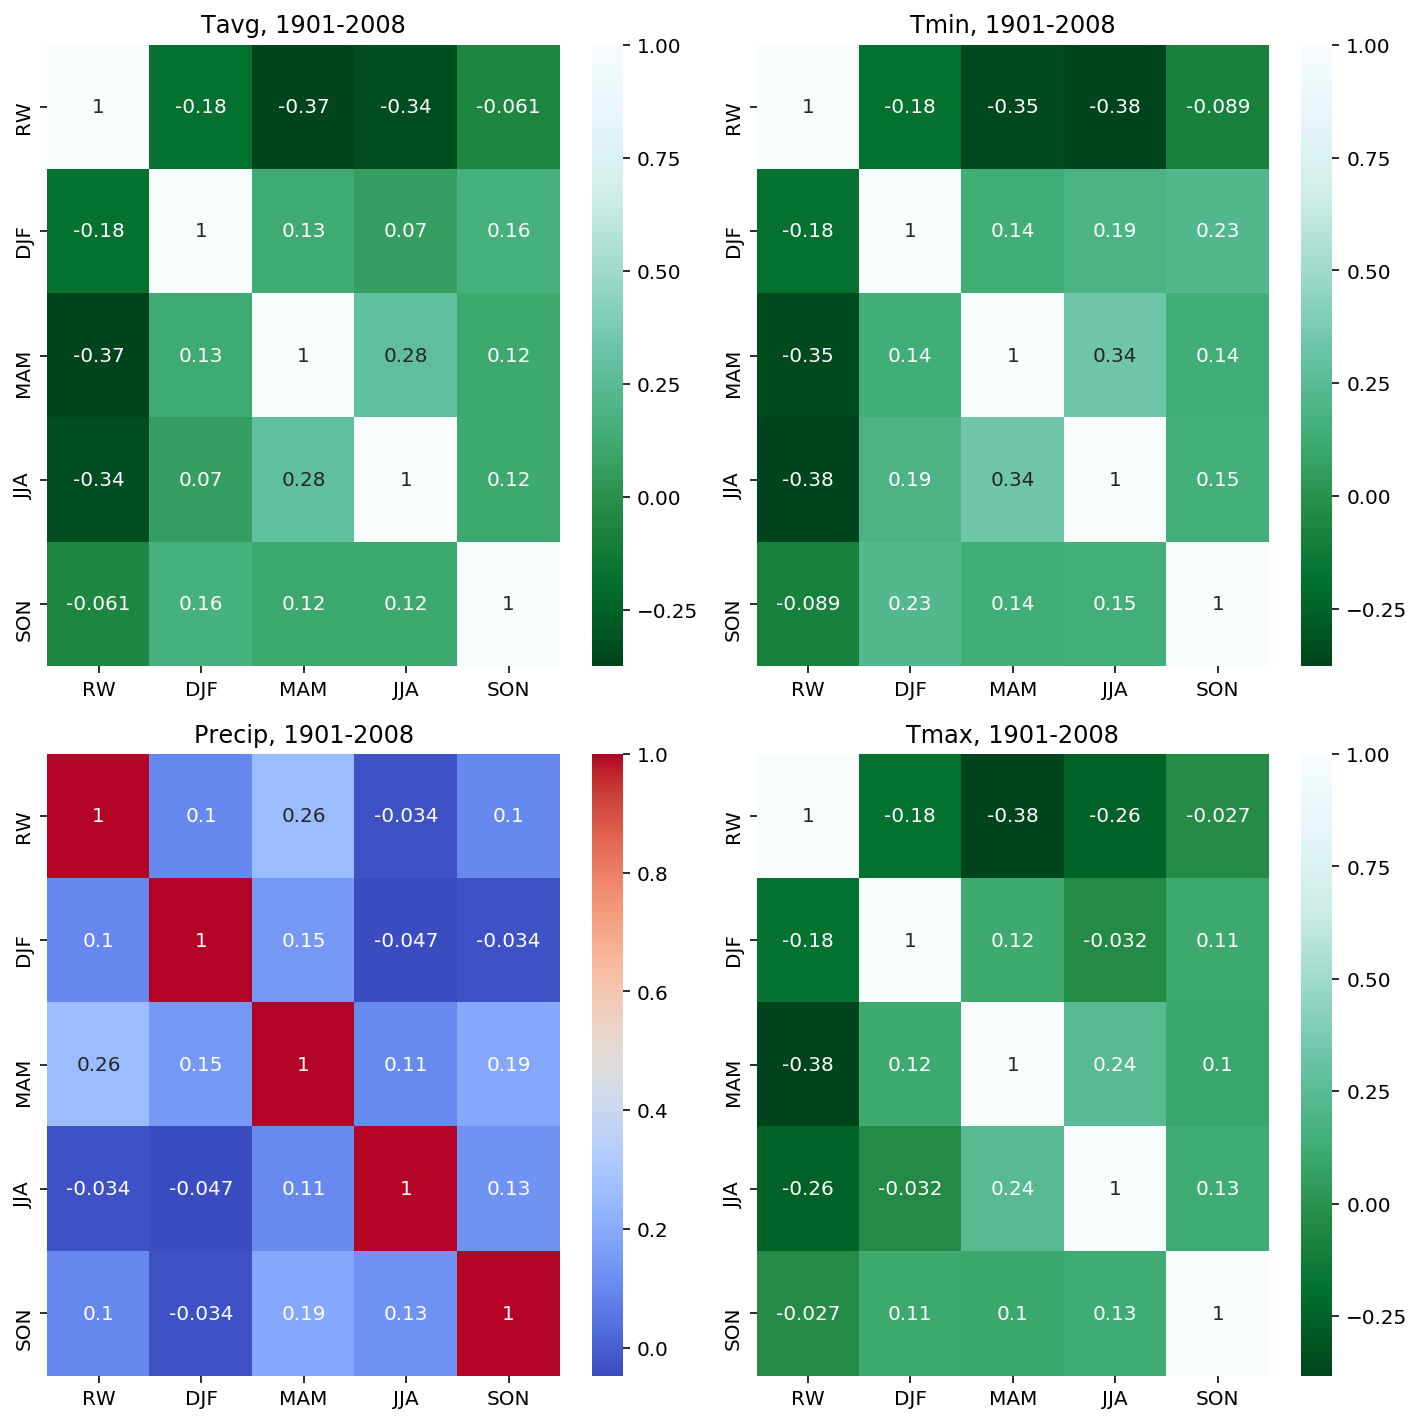

In [23]:

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10, 10) )
sns.heatmap(tavg_DF.corr(), annot=True, ax = ax[0,0],cmap="BuGn_r")
ax[0,0].set_ylim(5,0)
ax[0,0].set_title("Tavg, 1901-2008")

sns.heatmap(tmin_DF.corr(), annot=True, ax = ax[0,1], cmap="BuGn_r")
ax[0,1].set_ylim(5,0)
ax[0,1].set_title("Tmin, 1901-2008")

sns.heatmap(tmax_DF.corr(), annot=True, ax = ax[1,1], cmap="BuGn_r")
ax[1,1].set_ylim(5,0)
ax[1,1].set_title("Tmax, 1901-2008")
fig.tight_layout()

sns.heatmap(p_DF.corr(), annot=True, ax = ax[1,0], cmap="coolwarm")
ax[1,0].set_ylim(5,0)
ax[1,0].set_title("Precip, 1901-2008")
fig.tight_layout()

## 3.B Pairwise Correlations for JJA, the growing season in AK 

- Note, Only  recently has the postive relationship with temperature shifted. 

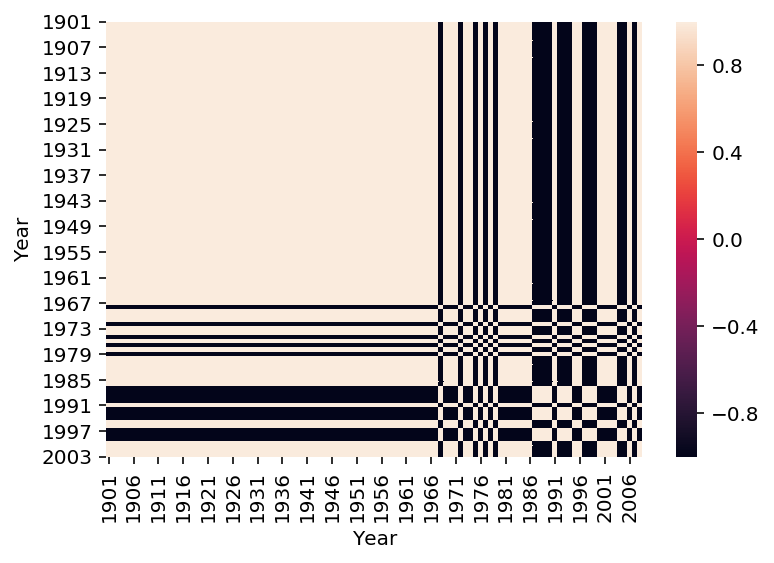

In [24]:
k=sns.heatmap(tavg_DF[['RW','JJA']].T.corr()) #transpose 

## 3.C Lagged Correlation tests 
- apply custom function to hold target(RW) , and lag rest 
- suggested by Andre Araujo 2018,

In [25]:
#lagging dataframe   function, suggested by Andre Araujo 2018
def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [26]:
#lagging seasonal variables by 1 year
df_new_tavg = df_shifted(tavg_DF, 'RW', lag=-1)
df_new_tavg.head()

,RW,DJF,MAM,JJA,SON
Year,,,,,
1901,1.089,-0.457919,-1.109934,0.141977,-0.313350
1902,1.075,-0.411230,-0.916321,-0.597414,-0.976559
1903,1.157,-1.059039,-0.326681,0.881369,-0.849368
1904,0.973,0.481696,1.363032,-0.227718,-0.068054
1905,1.099,-1.560945,0.544577,-0.474182,-0.222500


###   Lagged Correlations Plots:


Text(0.5, 0.98, 'Mean Correlations for Previous Year Climate ')

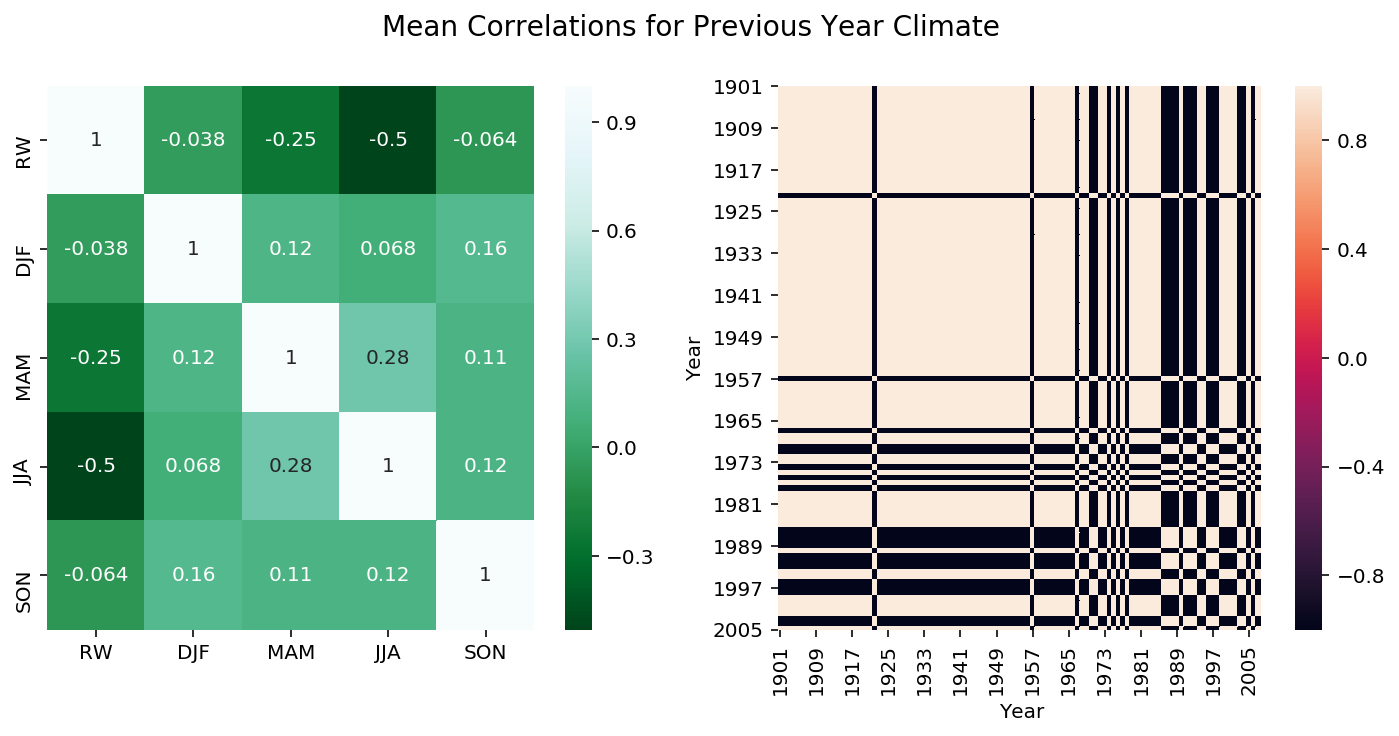

In [27]:
fig, ax = plt.subplots(ncols=2,figsize=(12,5) )
sns.heatmap(df_new_tavg.corr(), annot=True,cmap="BuGn_r",ax=ax[0], )#min and max temperature show similar neg corr for JJA
ax[0].set_ylim(5,0)
sns.heatmap(df_new_tavg[['RW','JJA']].T.corr(),xticklabels=8,yticklabels=8)
ax[1]

fig.suptitle("Mean Correlations for Previous Year Climate ", fontsize=14)

#### standardizing RAW ring width ,(easier for plotting comparisons)

In [28]:
raw=pd.read_csv('RWraw1901.csv')
rarw=raw['raw'].values
rw_z=((rarw-rarw.mean()))/rarw.std()

In [29]:
law=pd.read_csv('lw1901raw.csv',parse_dates = {'date_col' : ["year"]})
law['date_col'] = pd.to_datetime(law['date_col'])
lwr=law['raw'].values
lw_z=((lwr-lwr.mean()))/lwr.std()

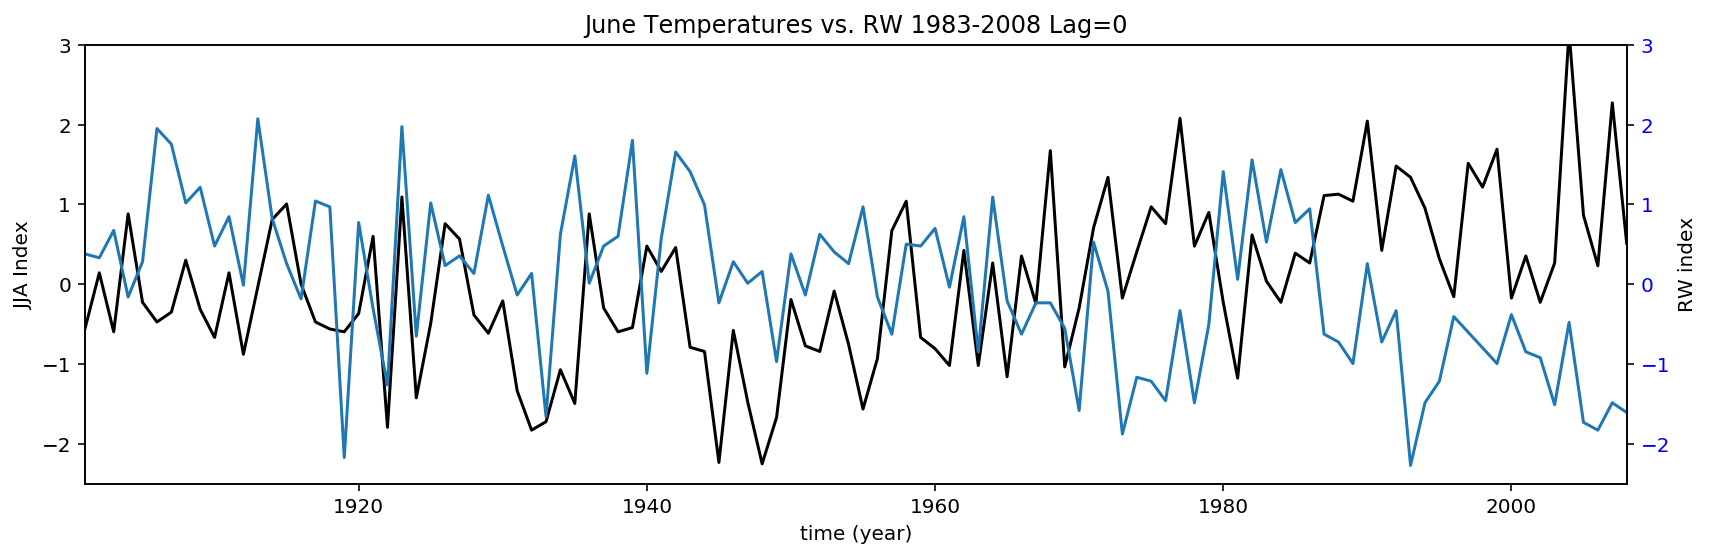

In [199]:
fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'k'
year=tavg_DF.index
ax1.set_xlabel('time (year)')
ax1.set_ylabel('JJA Index')
ax1.plot(year, tavg_DF[['JJA']],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim(-2.5,3)
ax1.set_xlim()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('RW index',)  # we already handled the x-label with ax1
ax2.plot(year, rw_z)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-2.5,3)
ax2.set_xlim(1901,2008)
ax2.set_title('June Temperatures vs. RW 1983-2008 Lag=0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



In [ ]:
## spatio temporal correlations with larger grid
! wget https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.03/cruts.1905011326.v4.03/tmp/cru_ts4.03.1901.2018.tmp.dat.nc.gz
! gunzip cru_ts4.03.1901.2018.tmp.dat.nc.gz


## 4A. Access CRU temp data directly 
- for larger spatial grid
- perhaps the standard seasonality isnt what is driving growth rings, need to look at individual months

In [30]:
d_sUl = xr.open_dataset('cru_ts4.03.1901.2018.tmp.dat.nc') #monthly climate data 
d_SUB = d_sUl.sel(time=slice('1985', '2008'),lon=slice(-170.25,-135.25),lat=slice(52.75,75.75)) #make


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Mean June Temperature (C) 1983-2008')

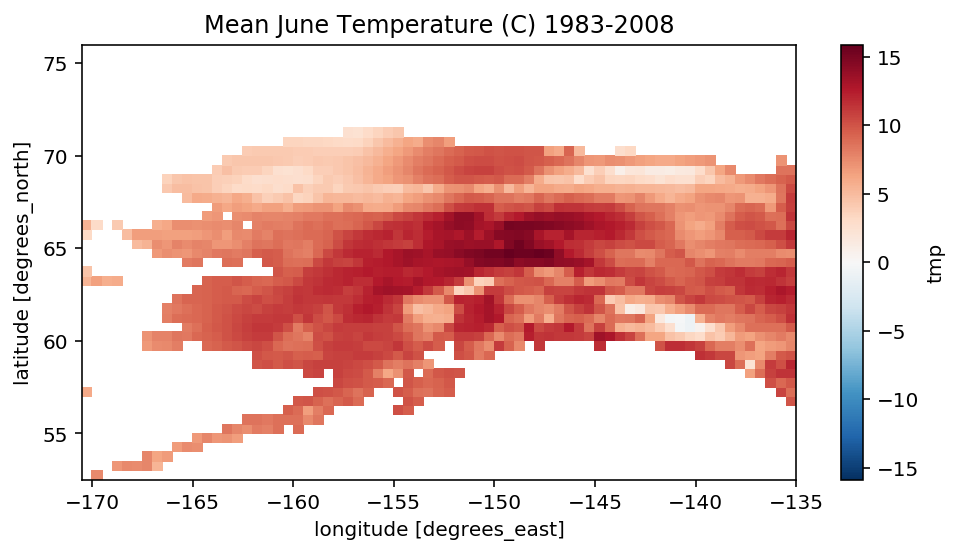

In [31]:
tsub=d_SUB.tmp # assign datavariable 
tmpJ = tsub.where((tsub['time.month']==6)&((tsub['time.year']<=2008)&(tsub['time.year']>=1983)),drop=True).groupby('time.year').mean(dim='time')

fig, ax = plt.subplots(figsize=(8, 4))
tmpJJA_sub=tmpJ.mean(dim=['year']).plot()
ax.set_title('Mean June Temperature (C) 1983-2008')




In [32]:
dst = xr.open_dataset('cru_ts4.03.1901.2018.tmp.dat.nc') #monthly climate data 
ds = dst.sel(time=slice('1901', '2008'),lon=slice(-155.25,-145.25),lat=slice(62.75,73.75)) #make

ds

<xarray.Dataset>
Dimensions:  (lat: 23, lon: 21, time: 1296)
Coordinates:
  * lon      (lon) float32 -155.25 -154.75 -154.25 ... -146.25 -145.75 -145.25
  * lat      (lat) float32 62.75 63.25 63.75 64.25 ... 72.25 72.75 73.25 73.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2008-12-16
Data variables:
    tmp      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.03 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 1905011326. Data generated from:tmp.1905011321.dtb
    history:      Wed  1 May 2019 15:42:51 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

### Apply Similar time slicing and indexing 
   - but looking at other months, and time periods (JUNE)
   - lagged correlations as well

In [33]:
tmpu=ds.tmp # assign datavariable 
tmpJu = tmpu.where((tmpu['time.month']==6)&((tmpu['time.year']<=2008)&(tmpu['time.year']>=1901)),drop=True).groupby('time.year').mean(dim='time')

#take the mean over the lat and lon axis
tmpJJAgrid=tmpJu.mean(dim=['lat','lon']) #take mean over grid
tmpJgrid=((tmpJJAgrid-tmpJJAgrid.mean(dim='year')))/tmpJJAgrid.std(dim='year') #standardize by time

g=tmpJgrid.values

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [34]:
tmpJ_std=((tmpJu-tmpJu.mean(dim='year')))/tmpJu.std(dim='year') #standardizing by time first
tmpJcoord=tmpJ_std.mean(dim=['lat','lon']) #then averaging across grid points 
h=tmpJcoord.T.values


/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [40]:
years=rw['Year']
d = {'RW': rw_z, 'J': g}
dfJ = pd.DataFrame(data=d, index=years)
recent=dfJ[-26:]
y=recent.index.values


In [36]:
dfJcorr = df_shifted(recent, 'RW', lag=-2) #lagging by 2 as a tests 

pearsoncorr=recent.T.corr(method='pearson')

lagcorr=dfJcorr.T.corr(method='pearson')


(15, 0)

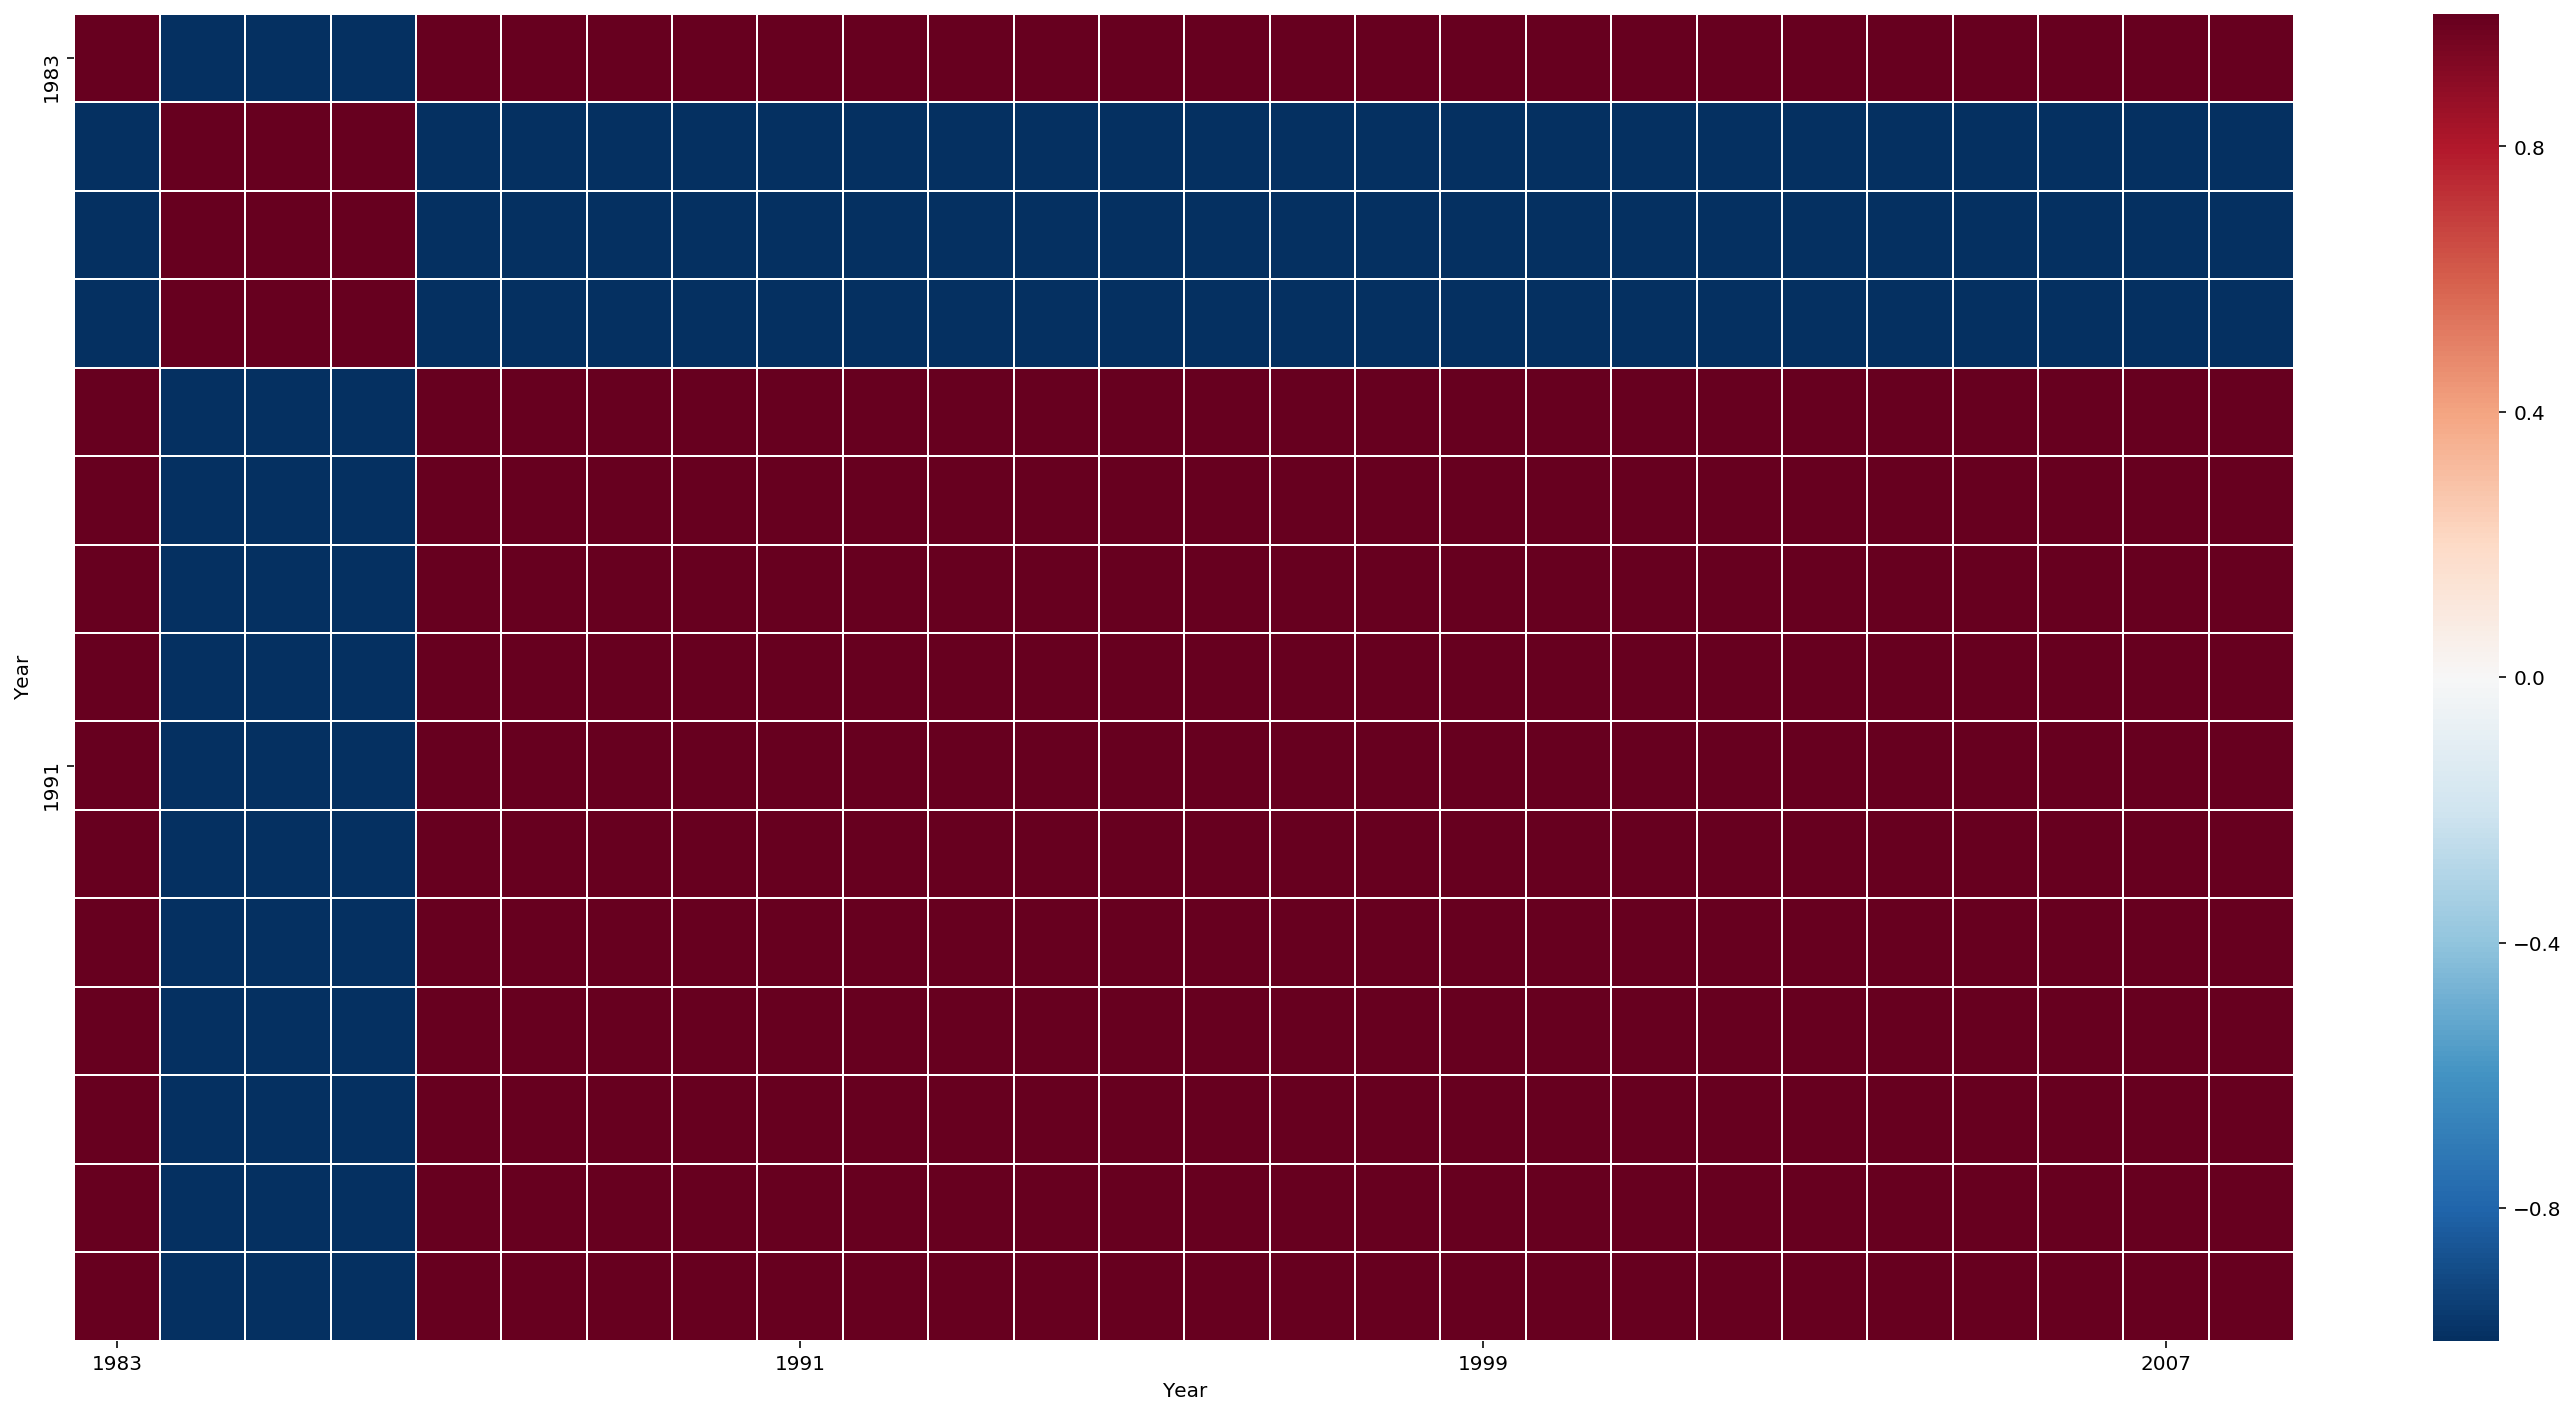

In [41]:
fig, ax = plt.subplots(figsize=(20,10) )

sns.heatmap(pearsoncorr, 
            xticklabels=8,yticklabels=8,
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)
fig.tight_layout()
ax.set_ylim(15,0)

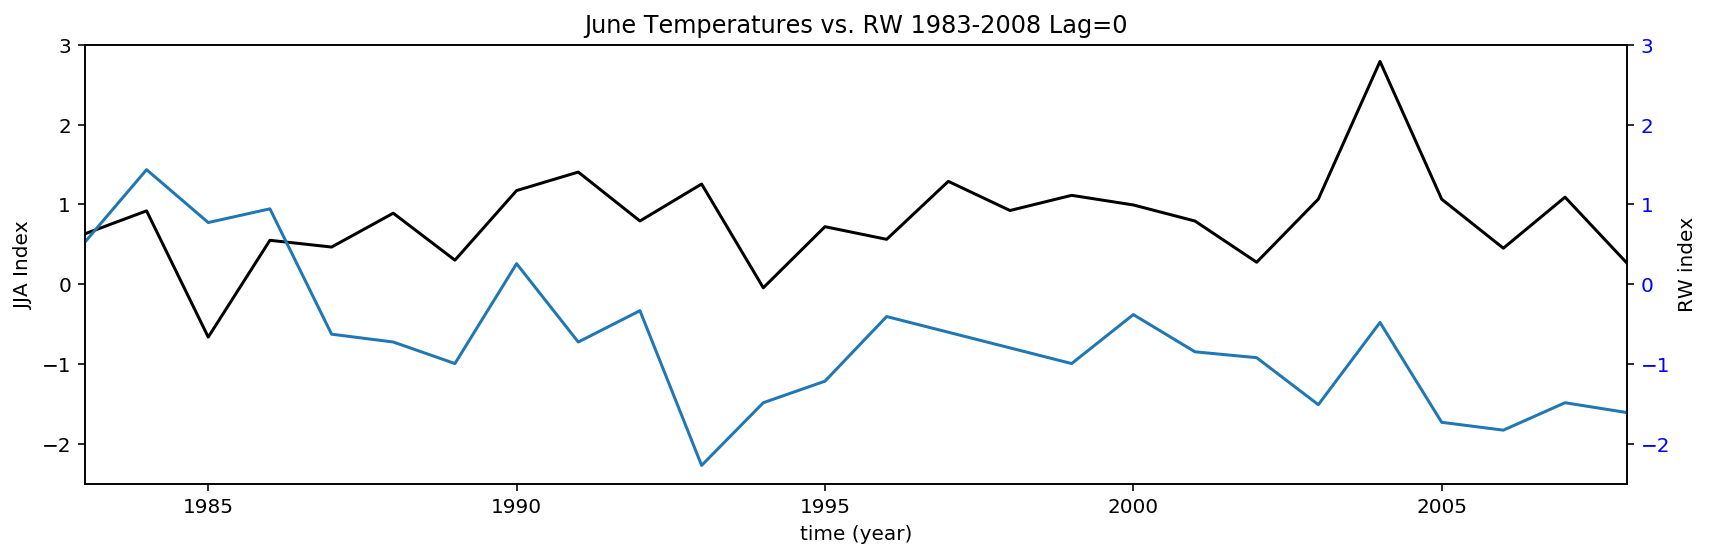

In [38]:

fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'k'
year=recent.index
ax1.set_xlabel('time (year)')
ax1.set_ylabel('JJA Index')
ax1.plot(year, recent[['J']],color=color)
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim(-2.5,3)
ax1.set_xlim()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('RW index',)  # we already handled the x-label with ax1
ax2.plot(year, recent[['RW']])
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-2.5,3)
ax2.set_xlim(1983, 2008)

ax2.set_title('June Temperatures vs. RW 1983-2008 Lag=0')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



## Why take the time to do this? 
- this site already as temperature reconstruction potential in the density parameter seen below
- having 700-1000 yrs of robust information about eco-climate at the boreal tree-line is imperative
- this recent trend  over700 years of growth  is interesting- 

## Preliminary assumptions:
-  the growing season is earlier in AK, in other words 
- Since the 1980s, the temperatures in the previous  summer season( dictate how much the tree will grow in the following season
- in other words: the hot summers cause the tree. to grow less (most. likely a drought response

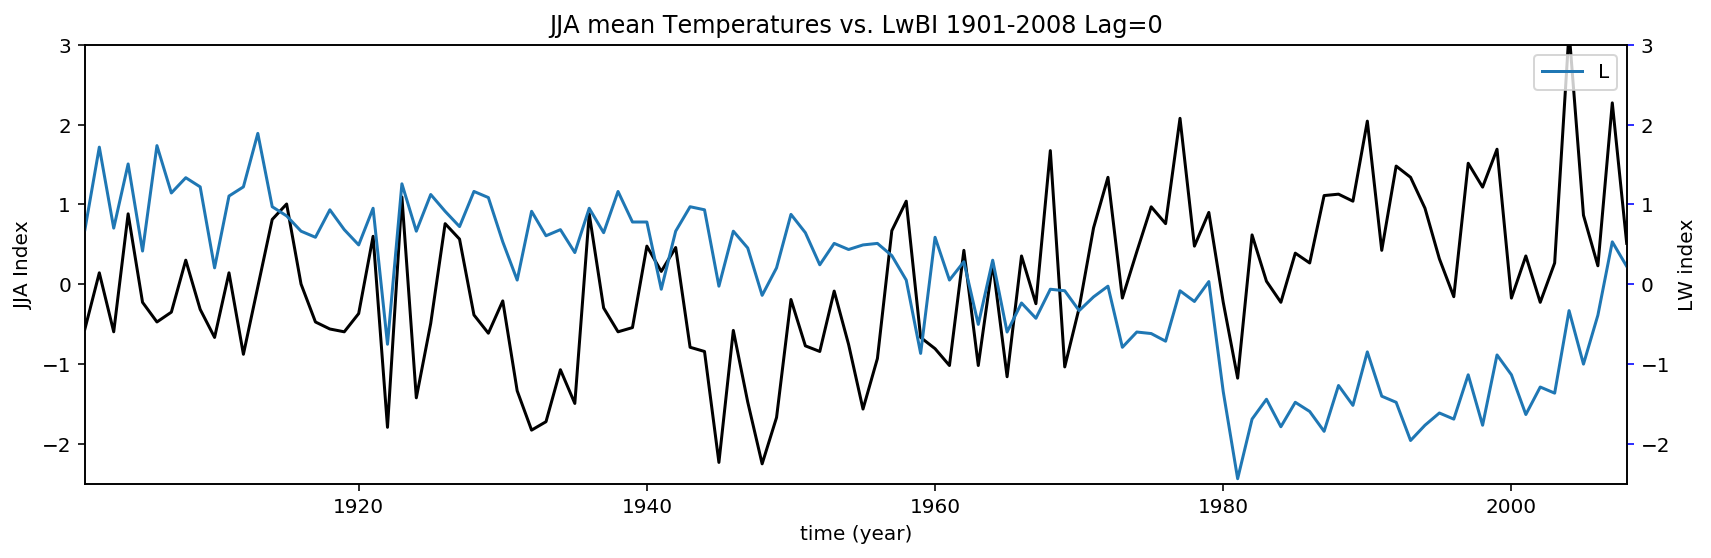

In [39]:
fig, ax1 = plt.subplots(figsize=(12, 4))
color = 'k'
year=tavg_DF[['JJA']].index
ax1.set_xlabel('time (year)')
ax1.set_ylabel('JJA Index')
ax1.plot(year, tavg_DF[['JJA']], color="k")
ax1.tick_params(axis='y',labelcolor=color)
ax1.set_ylim(-2.5,3)
ax1.set_xlim()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('LW index',)  # we already handled the x-label with ax1
ax2.plot(year, lw_z)
ax2.tick_params(axis='y', color="b")
ax2.set_ylim(-2.5,3)

ax2.set_title('JJA mean Temperatures vs. LwBI 1901-2008 Lag=0')
ax2.legend('LW')
ax2.set_xlim(1901, 2008)
fig.tight_layout()# otherwise the right y-label is slightly clipped
plt.show()




### Learning outcomes 
- Overall learned alot via documentation and translating my ideas into code
- lagged correlation vs. Dataframes
- for loops
- time indexing
- panda to xarray communication

### Major Challenges
- Attempting to concatenate spatial correlations into a data frame, or 
- correlate in general for 3D arrays

## TO DO
- SPEI
- PC analysis on individual Trees
- Clean up graphs & organize
